# Multi-label Classification Problem

### Импортируем необходимые пакеты

In [104]:
import pandas as pd
import numpy as np
import copy
import random
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm


from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, hamming_loss, make_scorer, log_loss
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import warnings

plt.style.use("seaborn-bright")
plt.style.use("bmh")
warnings.filterwarnings("ignore")


from IPython.display import display, HTML, Image


### Напишем функцию для отображения и подсчета пропущенных значений

In [105]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

### Загрузим и посмотрим на датасеты, почистим данные

In [106]:
labels_df = pd.read_csv("problem_labels.csv", index_col = 'id')
print("labels.shape: " + str(labels_df.shape))

labels_df.head()

labels.shape: (8000, 14)


,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
id,,,,,,,,,,,,,,
11193,1,1,0,0,0,0,0,0,0,1,1,0,0,0
11382,0,0,0,0,0,0,0,0,0,1,1,0,0,0
16531,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1896,0,0,0,1,0,0,0,0,0,1,0,1,0,0
18262,0,0,0,1,1,0,0,0,0,0,1,1,1,0


Проверим пропущенные значения в датасете labels

In [107]:
missing_zero_values_table(labels_df)

Your selected dataframe has 14 columns and 8000 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


Пропущенных значений нет. Принадлежность классу обозначается единицой, значит можем проверить количество объектов в каждом классе операцией суммирования.
Просуммируем количество объектов в каждом классе и узнаем для каждого класса также долю объектов, принадлежащих классу, от всех объектов (в процентах).

In [108]:
sums = labels_df.select_dtypes(pd.np.number).sum().rename('total')
print(sums)
print(100*sums/len(labels_df))

service_a    3777
service_b    2626
service_c    2093
service_d     136
service_e     431
service_f     233
service_g     415
service_h    2376
service_i     129
service_j    6786
service_k    6256
service_l     864
service_m     709
service_n    1424
Name: total, dtype: int64
service_a    47.2125
service_b    32.8250
service_c    26.1625
service_d     1.7000
service_e     5.3875
service_f     2.9125
service_g     5.1875
service_h    29.7000
service_i     1.6125
service_j    84.8250
service_k    78.2000
service_l    10.8000
service_m     8.8625
service_n    17.8000
Name: total, dtype: float64


Максимально не сбалансированными классами для обучения являются "service_d" и "service_i", к ним относятся около 130 объектов из 8000 (менее 2% объектов)

Посмотрим на корреляцию между классами

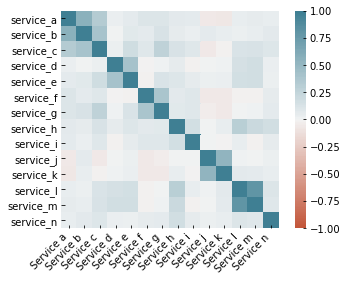

In [109]:
corr = labels_df.corr()# plot the heatmap
ax = sns.heatmap(corr, 
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

for i, label in enumerate(ax.get_xticklabels()):
    ax.get_xticklabels()[i].set_text(corr.index[i].capitalize().replace('_', ' '))
    
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right');

for i, label in enumerate(ax.get_yticklabels()):
    ax.get_yticklabels()[i].set_text(corr.index[i].capitalize().replace('_', ' '))

Наблюдается высокая корреляция между некоторыми парами классов, например l и m, j и k, a и b

Загрузим основной тренировочный датасет

In [110]:
train_df = pd.read_csv("problem_train.csv", index_col = 'id')
print("train.shape: " + str(train_df.shape))

train_df.head()

train.shape: (8000, 1378)


,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0008,...,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
id,,,,,,,,,,,,,,,,,,,,,
11193,a,NaN,NaN,0.025449,NaN,NaN,0.368421,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN,NaN
11382,a,NaN,NaN,0.031297,NaN,NaN,0.315789,NaN,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,NaN,NaN,NaN,NaN
16531,a,NaN,NaN,0.024475,NaN,NaN,0.342105,NaN,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,b,NaN,NaN,NaN
1896,a,NaN,NaN,0.041694,NaN,NaN,0.447368,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
18262,c,NaN,NaN,0.038120,NaN,NaN,0.315789,NaN,NaN,NaN,...,NaN,NaN,b,NaN,a,NaN,a,NaN,NaN,NaN


посмотрим на описательные характеристики датасета train

In [111]:
train_df.describe()

,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0008,n_0009,...,c_1072,c_1129,c_1148,c_1168,c_1230,c_1257,c_1277,c_1281,c_1308,c_1332
count,12.000000,388.000000,7662.000000,112.000000,58.000000,7658.000000,1348.000000,995.000000,5.000000,34.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.307692,0.655744,0.040935,0.102749,0.352874,0.395981,0.193175,0.012012,0.422222,0.129241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.245454,0.216399,0.024599,0.153007,0.209337,0.085000,0.236683,0.041382,0.395967,0.162008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.134615,0.428571,0.031974,0.011905,0.200000,0.342105,0.000000,0.000000,0.111111,0.015560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.307692,0.702381,0.041369,0.047619,0.283333,0.394737,0.200000,0.000000,0.444444,0.049793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.403846,0.857143,0.048950,0.142857,0.525000,0.421053,0.400000,0.011905,0.555556,0.186722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,0.846154,1.000000,1.000000,1.000000,0.833333,1.000000,1.000000,1.000000,1.000000,0.597510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проверим пропущенные значения в датасете train, сохраним результаты для дальнейшей визуализации

In [112]:
train_df_missing_table = missing_zero_values_table(train_df)
train_df_missing_table

Your selected dataframe has 1378 columns and 8000 Rows.
There are 1347 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
c_1129,0,8000,100.0,8000,100.0,float64
c_0710,0,8000,100.0,8000,100.0,float64
c_0529,0,8000,100.0,8000,100.0,float64
c_0902,0,8000,100.0,8000,100.0,float64
c_1281,0,8000,100.0,8000,100.0,float64
...,...,...,...,...,...,...
c_0582,0,5,0.1,5,0.1,object
c_0709,0,5,0.1,5,0.1,object
c_0975,0,4,0.0,4,0.0,object
c_0996,0,3,0.0,3,0.0,object


Как видим, есть фичи, состоящие полностью из пропущенных значений, смысловой нагрузки они не несут. Попробуем визуализировать плотность распределения пропущенных значений от количества пропущенных значений. Для наглядности отметим уровни в 95% и 90% пропущенных значений

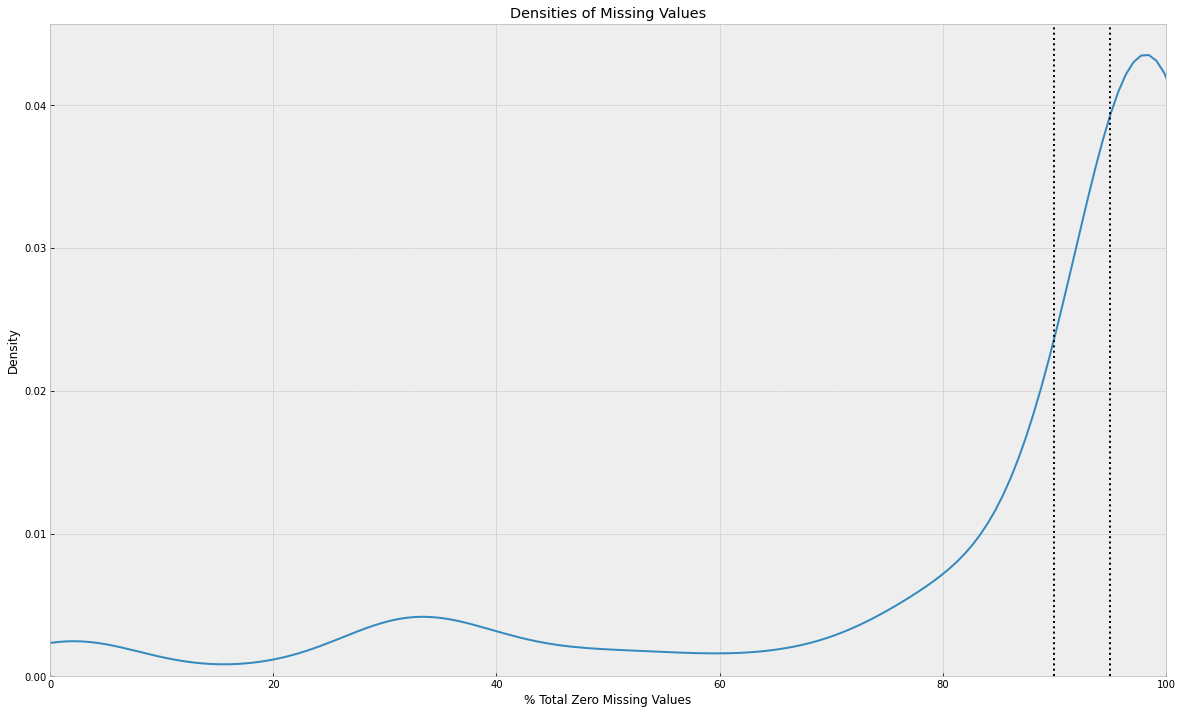

In [113]:
fig = plt.figure(figsize=(20,12))
plotMV = sns.kdeplot(train_df_missing_table['% Total Zero Missing Values'], label='Missing_Values')
plt.xlabel("% Total Zero Missing Values")
plt.title("Densities of Missing Values")
plotMV.set_xlim(0, 100)
xcoords = [95, 90]
for xc in xcoords:
    plt.axvline(x=xc, ls=":", lw = 2, color = "black")

Как видим, значительная часть фичей имеет более 90% пропущенных значений.
Однако здесь же стоит отметить, что у нас есть классы, в которых около 130 объектов, что составляет менее 2% всех объектов. 
С целью минимизации количества колонок я выбрал в качестве трешхолда на минимальное количество не пропущенных значений в датасете уровень 10% от 130 объектов, т.е. 13. То есть я оставил колонки в которых пропущенных значений не больше: 8000 - (130 * 10%) = 7987

In [114]:
train_df = train_df.dropna(thresh=len(train_df) - 7987, axis=1)
print("train.shape: " + str(train_df.shape))
train_df.describe()

train.shape: (8000, 1048)


,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0009,n_0010,n_0012,...,o_0312,o_0313,o_0314,o_0315,o_0316,o_0319,o_0322,o_0323,o_0324,o_0326
count,388.000000,7662.000000,112.000000,58.000000,7658.000000,1348.000000,995.000000,34.000000,26.000000,5536.000000,...,270.000000,76.000000,1695.00000,4001.000000,397.000000,671.000000,182.000000,1694.000000,550.000000,743.000000
mean,0.655744,0.040935,0.102749,0.352874,0.395981,0.193175,0.012012,0.129241,0.361538,0.175514,...,16.488889,2.078947,0.00354,0.086978,5.080605,5.651267,18.675824,0.009445,1.209091,5.282638
std,0.216399,0.024599,0.153007,0.209337,0.085000,0.236683,0.041382,0.162008,0.204112,0.095125,...,5.863207,1.572795,0.06863,0.322386,3.416914,3.442577,6.327120,0.137157,0.699928,3.470446
min,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.428571,0.031974,0.011905,0.200000,0.342105,0.000000,0.000000,0.015560,0.200000,0.097561,...,12.000000,1.000000,0.00000,0.000000,2.000000,3.000000,14.000000,0.000000,1.000000,2.000000
50%,0.702381,0.041369,0.047619,0.283333,0.394737,0.200000,0.000000,0.049793,0.300000,0.170732,...,17.000000,2.000000,0.00000,0.000000,5.000000,6.000000,19.000000,0.000000,1.000000,5.000000
75%,0.857143,0.048950,0.142857,0.525000,0.421053,0.400000,0.011905,0.186722,0.400000,0.256098,...,21.000000,4.000000,0.00000,0.000000,8.000000,9.000000,23.750000,0.000000,2.000000,8.000000
max,1.000000,1.000000,1.000000,0.833333,1.000000,1.000000,1.000000,0.597510,1.000000,0.353659,...,29.000000,4.000000,2.00000,5.000000,11.000000,11.000000,32.000000,3.000000,2.000000,11.000000


Проверим снова пропущенные значения в датасете train

In [115]:
stats_table = missing_zero_values_table(train_df)
stats_table

Your selected dataframe has 1048 columns and 8000 Rows.
There are 1017 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
c_0780,0,7987,99.8,7987,99.8,object
c_0501,0,7987,99.8,7987,99.8,object
o_0131,1,7987,99.8,7988,99.8,float64
c_0976,0,7987,99.8,7987,99.8,object
c_0849,0,7987,99.8,7987,99.8,object
...,...,...,...,...,...,...
c_0709,0,5,0.1,5,0.1,object
c_0582,0,5,0.1,5,0.1,object
c_0975,0,4,0.0,4,0.0,object
c_0996,0,3,0.0,3,0.0,object


Количество колонок сократилось с 1378 до 1048 (примерно на четверть)

Проверим наличие в train датасете строк, в которых нет значений

In [116]:
train_df_row_test = train_df.dropna(axis = 0, how = 'all')
train_df_row_test.shape

(8000, 1048)

Убедились, что таких строк нет

Загрузим тестовый датасет, приведем его колонки в соотвествие с очищенным тренировочным датасетом. 

In [117]:
test_df = pd.read_csv("problem_test.csv", index_col = 'id')
common_cols_train_test = list(set(test_df.columns).intersection(train_df.columns))
test_df = test_df[common_cols_train_test]
test_df.shape

(2000, 1048)

В дальнейшем в процессе классификации хотелось бы использовать бинарную классификацию для каждого лейбла. Для этого переведем категориальные переменные в количественные, используя one-hot encoding. Проводить данную операцию я буду над датасетом, состоящим из тренировочного и тестового, тк вероятна ситуация появления в тестовом датасете объектов, отсутствующих в тренировочном датасете.

In [118]:
df_for_encoding = pd.concat([train_df, test_df], ignore_index=False)
df_for_encoding.shape

(10000, 1048)

In [119]:
categorical_cols2 = df_for_encoding.select_dtypes(include=['object']).columns
df_for_encoding = pd.get_dummies(df_for_encoding, columns=categorical_cols2, prefix=categorical_cols2)
print(df_for_encoding)

       n_0001    n_0002  n_0003  n_0004    n_0005  n_0006    n_0007  n_0009  \
id                                                                            
11193     NaN  0.025449     NaN     NaN  0.368421     NaN       NaN     NaN   
11382     NaN  0.031297     NaN     NaN  0.315789     NaN       NaN     NaN   
16531     NaN  0.024475     NaN     NaN  0.342105     NaN       NaN     NaN   
1896      NaN  0.041694     NaN     NaN  0.447368     NaN       NaN     NaN   
18262     NaN  0.038120     NaN     NaN  0.315789     NaN       NaN     NaN   
...       ...       ...     ...     ...       ...     ...       ...     ...   
200       NaN  0.014728     NaN     NaN  0.368421     NaN  0.059524     NaN   
10876     NaN  0.052415     NaN     NaN  0.578947     NaN  0.000000     NaN   
4035      NaN  0.038770     NaN     NaN  0.368421     NaN       NaN     NaN   
3640      NaN  0.039420     NaN     NaN  0.552632     NaN       NaN     NaN   
157       NaN  0.043535     NaN     NaN  0.421053   

Разделим получившийся датасет обратно на тренировчный и тестовый по первоначальному количеству строк (8000 и 2000)

In [120]:
train_df_copy = df_for_encoding.head(8000)
test_df_copy = df_for_encoding.tail(len(df_for_encoding) - 8000)
train_df_copy.shape

(8000, 5414)

Для бинарной классификации также потребуется отсутствие пропущенных значений. Заменим их в тестовом и тренировочном датасетах на медианное значение. Также проводил тест с заменой пропущенных значений наиболее часто встречающимся значением по столбцу (модой), результаты были хуже, остальной код был таким же, поэтому не вижу смысла оставлять это в  описании пути поиска решения.

In [121]:
median = train_df_copy.median().to_dict()
train_df_copy.fillna(median, inplace=True)
train_df_copy

,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0009,n_0010,n_0012,...,c_1375_m,c_1375_n,c_1375_o,c_1375_p,c_1375_q,c_1375_r,c_1375_s,c_1375_t,c_1377_a,c_1377_b
id,,,,,,,,,,,,,,,,,,,,,
11193,0.702381,0.025449,0.047619,0.283333,0.368421,0.2,0.0,0.049793,0.3,0.292683,...,0,0,0,0,0,0,0,0,0,0
11382,0.702381,0.031297,0.047619,0.283333,0.315789,0.2,0.0,0.049793,0.3,0.243902,...,0,0,0,0,0,0,0,0,0,0
16531,0.702381,0.024475,0.047619,0.283333,0.342105,0.2,0.0,0.049793,0.3,0.304878,...,0,0,0,0,0,0,0,0,0,0
1896,0.702381,0.041694,0.047619,0.283333,0.447368,0.2,0.0,0.049793,0.3,0.207317,...,0,0,0,0,0,0,0,0,0,0
18262,0.702381,0.038120,0.047619,0.283333,0.315789,0.2,0.0,0.049793,0.3,0.219512,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10898,0.702381,0.053931,0.047619,0.283333,0.394737,0.2,0.0,0.049793,0.3,0.060976,...,0,0,0,0,0,0,0,0,0,1
16664,0.702381,0.031731,0.047619,0.283333,0.394737,0.2,0.0,0.049793,0.3,0.268293,...,0,0,0,0,0,0,0,0,0,0
5334,0.904762,0.033463,0.047619,0.283333,0.394737,0.2,0.0,0.049793,0.3,0.304878,...,0,0,0,0,0,0,0,0,0,0


In [122]:
median_test = test_df_copy.median().to_dict()
test_df_copy.fillna(median_test, inplace=True)
test_df_copy

,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0009,n_0010,n_0012,...,c_1375_m,c_1375_n,c_1375_o,c_1375_p,c_1375_q,c_1375_r,c_1375_s,c_1375_t,c_1377_a,c_1377_b
id,,,,,,,,,,,,,,,,,,,,,
7957,0.678571,0.029890,0.063492,0.283333,0.368421,0.2,0.000000,0.049793,0.35,0.329268,...,0,0,0,0,0,0,0,0,0,0
693,0.452381,0.032164,0.063492,0.283333,0.421053,0.0,0.000000,0.049793,0.35,0.341463,...,0,0,0,0,0,0,0,0,0,0
15558,0.547619,0.049166,0.063492,0.283333,0.500000,0.2,0.000000,0.049793,0.35,0.219512,...,0,0,0,0,0,0,0,0,0,0
15614,0.678571,0.048733,0.063492,0.283333,0.394737,0.2,0.000000,0.049793,0.35,0.134146,...,0,0,0,0,0,0,0,0,0,0
8149,0.678571,0.049924,0.063492,0.283333,0.368421,0.2,0.000000,0.049793,0.35,0.170732,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.678571,0.014728,0.063492,0.283333,0.368421,0.2,0.059524,0.049793,0.35,0.170732,...,0,0,0,0,0,0,0,0,0,0
10876,0.678571,0.052415,0.063492,0.283333,0.578947,0.2,0.000000,0.049793,0.35,0.170732,...,0,0,0,0,0,0,0,0,0,0
4035,0.678571,0.038770,0.063492,0.283333,0.368421,0.2,0.000000,0.049793,0.35,0.170732,...,0,0,0,0,0,0,0,0,0,0


### Разделим датасеты на train и test части

In [123]:
X_train, X_test, y_train, y_test = train_test_split(train_df_copy, labels_df, random_state=0, train_size=0.7)

print("X_train.shape: " + str(X_train.shape))
print("X_test.shape: " + str(X_test.shape))
print("y_train.shape: " + str(y_train.shape))
print("y_test.shape: " + str(y_test.shape))

X_train.shape: (5600, 5414)
X_test.shape: (2400, 5414)
y_train.shape: (5600, 14)
y_test.shape: (2400, 14)


### Реализуем бинарный классификатор с необходимым функционалом

In [124]:
class BinaryRelevanceClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=LogisticRegression()):
        self.base_classifier=base_classifier

    def fit(self, X, y):
        self.models = []
        for label in list(y.columns):
            x_checked, y_checked = check_X_y(X, y[label])
            base_model = clone(self.base_classifier)
            basel_model = base_model.fit(x_checked, y_checked)
            self.models.append(base_model)

    def predict(self, X):
        check_is_fitted(self, ['models'])
        X = check_array(X)
        all_preds = pd.DataFrame()
        i=0
        preds = []
        for model in self.models:
            pred = model.predict(X)
            preds.append(pd.DataFrame({'Class'+ str(i+1): pred}))
            i+=1
        all_preds = pd.concat(preds, axis=1)
        return all_preds.to_numpy()
    
    def predict_proba(self,X):
        check_is_fitted(self, ['models'])
        X = check_array(X)      
        all_preds = pd.DataFrame()
        i = 0       
        for model in self.models:
            pred = model.predict_proba(X)
            all_preds['Class'+str(i+1)] = [one_prob[1] for one_prob in pred]
            i+=1
        return all_preds.to_numpy()

Создадим классифаер, зафитим и запредиктим

In [125]:
br_clf = BinaryRelevanceClassifier(LogisticRegression())
br_clf.fit(X_train, y_train)
y_pred = br_clf.predict(X_test)
print("y_pred.shape: " + str(y_pred.shape))

y_pred.shape: (2400, 14)


Напишем функцию расчета метрики точности для классифаеров

In [126]:
def accuracy_score(y_test, y_pred):
    y_test = y_test.to_numpy()
    assert y_test.shape == y_pred.shape
    i=0
    scores = []
    while i < len(y_test):
        count=0
        for p, q in zip(y_test[i], y_pred[i]):
            if p == q:
                count += 1
        scores.append(count / y_pred.shape[1])
        i+=1 
    return round((sum(scores)/len(y_test)), 5)

In [127]:
print("Accuracy of Binary Relevance Classifier: " + str(accuracy_score(y_test, y_pred)))

Accuracy of Binary Relevance Classifier: 0.86952


Попробуем поискать параметры для классифаера, которые дадут нам более точные результаты

In [128]:
cv_folds=5

param_grid ={'base_classifier': [DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2),
                                 RandomForestClassifier(criterion='entropy'),
                                 LogisticRegression(max_iter=20000), GaussianNB(), KNeighborsClassifier(), SVC()] }

tuned_model = GridSearchCV(BinaryRelevanceClassifier(), \
                            param_grid, scoring=make_scorer(accuracy_score), verbose = 2, n_jobs = -1, cv=cv_folds)
tuned_model.fit(X_train, y_train)

print("Best Parameters Found: ")
display(tuned_model.best_params_)
display(tuned_model.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters Found: 


{'base_classifier': RandomForestClassifier(criterion='entropy')}

0.873432

Создадим классифаер с подобранными параметрами

In [129]:
br_clf2 = BinaryRelevanceClassifier(RandomForestClassifier(criterion='entropy'))
br_clf2.fit(X_train, y_train)
y_pred2 = br_clf2.predict(X_test)
print("y_pred.shape: " + str(y_pred2.shape))

y_pred.shape: (2400, 14)


In [131]:
print("Accuracy of Binary Relevance Classifier - Best Model: " + str(accuracy_score(y_test, y_pred2)))

Accuracy of Binary Relevance Classifier - Best Model: 0.87185


Сохраним результаты предсказания лейблов для тестового датасета

In [132]:
best_result_based_on_accuracy_proba = br_clf2.predict_proba(test_df_copy)
print(best_result_based_on_accuracy_proba.shape)

(2000, 14)


### Реализуем бинарный классификатор с андерсемплингом 

Как мы видели в процессе исследования данных, датасет лейблов не является сбалансированным, поэтому попробуем посмотреть на результаты бинарной классификации с андерсемплингом

In [133]:
class BinaryRelevanceClassifierUS(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=LogisticRegression(max_iter=20000)):
        self.base_classifier=base_classifier

    def fit(self, X, y):
        self.models = []
        for label in list(y.columns):          
            X_cp = X.copy()
            y_cp = y[label]
            X_y_data = pd.concat([X_cp, y_cp], axis=1)
            n_val0, n_val1 = 0,0         
            j=0
            while j<len(X_y_data):
                if(X_y_data.iloc[j][label] == 0):
                    n_val0+=1
                else:
                    n_val1+=1
                j+=1
            if n_val0 > n_val1:
                val1 = X_y_data[X_y_data[label]==1]
                val0 = X_y_data[X_y_data[label]==0].sample(n_val1)              
                X_y_data = pd.concat([val0, val1], axis=0)           
            elif n_val1 > n_val0:
                val1 = X_y_data[X_y_data[label]==1].sample(n_val0)
                val0 = X_y_data[X_y_data[label]==0]              
                X_y_data = pd.concat([val0, val1], axis=0)
            X_cp = X_y_data.iloc[:, :-1]
            y_cp = X_y_data.iloc[:, -1]            
            base_model = clone(self.base_classifier)
            a, b = check_X_y(X_cp, y_cp)
            base_model.fit(a, b)
            self.models.append(base_model)

    def predict(self, X):
        check_is_fitted(self, ['models'])
        X = check_array(X)       
        all_preds = pd.DataFrame()
        i=0
        preds = []
        for model in self.models:
            pred = model.predict(X)
            preds.append(pd.DataFrame({'Class'+ str(i+1): pred}))
            i+=1
        all_preds = pd.concat(preds, axis=1)
        return all_preds.to_numpy()
     
    def predict_proba(self,X):
        check_is_fitted(self, ['models'])
        X = check_array(X)       
        all_preds = pd.DataFrame()
        i = 0       
        for model in self.models:
            pred = model.predict_proba(X)
            all_preds['Class'+str(i+1)] = [one_prob[1] for one_prob in pred]
            i+=1
        return all_preds.to_numpy()

In [134]:
brus_clf = BinaryRelevanceClassifierUS()
brus_clf.fit(X_train, y_train)
y_pred = brus_clf.predict(X_test)
print("y_pred.shape=" + str(y_pred.shape))

y_pred.shape=(2400, 14)


In [135]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Binary Relevance Classifier with Under-sampling: " + str(accuracy))

Accuracy of Binary Relevance Classifier with Under-sampling: 0.73574


In [136]:
cv_folds=5

param_grid ={'base_classifier': [DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2),
                                 RandomForestClassifier(criterion='entropy'),
                                 LogisticRegression(max_iter=20000), GaussianNB(), KNeighborsClassifier(), SVC()] }

tuned_model = GridSearchCV(BinaryRelevanceClassifierUS(), \
                            param_grid, scoring=make_scorer(accuracy_score), verbose = 2, n_jobs = -1, cv=cv_folds)
tuned_model.fit(X_train, y_train)

print("Best Parameters Found: ")
display(tuned_model.best_params_)
display(tuned_model.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters Found: 


{'base_classifier': RandomForestClassifier(criterion='entropy')}

0.7533299999999999

In [137]:
brus_clf2 = BinaryRelevanceClassifierUS(RandomForestClassifier(criterion='entropy'))
brus_clf2.fit(X_train, y_train)
y_pred_brus2 = brus_clf2.predict(X_test)
print("y_pred.shape=" + str(y_pred_brus2.shape))

y_pred.shape=(2400, 14)


In [138]:
accuracy = accuracy_score(y_test, y_pred_brus2)
print("Accuracy of Binary Relevance Classifier with Under-sampling - Best Model: " + str(accuracy))

Accuracy of Binary Relevance Classifier with Under-sampling - Best Model: 0.74604


Как видим результаты хуже, чем в предыдущем эксперименте. Данный результат объясняется тем, что в процессе андерсемплинга мы теряем данные с целью сбалансировать классы по лейблам.

### Реализуем алгоритм Classifier Chains

Основная проблема бинарной классификации в том, что она не учитывает связи между лейблами. Попробуем реализовать алгоритм Classfier Chains, чтобы справиться с этой проблемой.

P.S. Сначала реализовал алгоритм, но спутал названия столбцов в лейбл датасете, позже было проще заменить названия столбцов в лейбл датасете, чем переписывать реализацию классифаера

In [139]:
new_col_names = ["Class"+str(i) for i in range(1, 15)]

col_name_map = dict(zip(y_train.columns, new_col_names))
col_name_map2 = dict(zip(y_test.columns, new_col_names))

y_train.rename(columns=col_name_map, inplace=True)
y_test.rename(columns=col_name_map2, inplace=True)


In [140]:
class ClassifierChains(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=LogisticRegression(max_iter=20000), order=None):
        self.base_classifier=base_classifier
        self.order = order

    def fit(self, X, y):
        if self.order is None:
            self.order = list(range(y.shape[1]))
        elif self.order == 'random':
            self.order = list(range(y.shape[1]))
            random.shuffle(self.order)
        else:
            if(len(self.order)==y.shape[1]):
                self.order = [o - 1 for o in self.order]
        self.models = [clone(self.base_classifier) for clf in range(y.shape[1])]
        X_joined = X.copy()
        for val in self.order:
            X_joined = pd.concat([X_joined, y['Class'+str(val+1)]], axis=1)
        for chain_index, model in enumerate(self.models):
            y_vals = y.loc[:, 'Class'+str(self.order[chain_index]+1)]
            t_X = X_joined.iloc[:, :(X.shape[1]+chain_index)]
            check_X_y(t_X, y_vals)
            model.fit(t_X, y_vals)

    def predict(self, X):
        check_is_fitted(self, ['models'])
        pred_chain = pd.DataFrame(columns=['Class'+str(o+1) for o in self.order])       
        X_copy = X.copy()
        X_joined = X.copy()
        X_joined.reset_index(drop=True, inplace=True)
        X_copy.reset_index(drop=True, inplace=True)
        i=0
        for chain_index, model in enumerate(self.models):
            prev_preds = pred_chain.iloc[:, :chain_index]
            X_joined = pd.concat([X_copy, prev_preds], axis=1)
            pred = model.predict(X_joined)
            pred_chain['Class'+str(self.order[i]+1)] = pred
            i+=1
        pred_chain = pred_chain.loc[:, ['Class'+str(j+1) for j in range(0, len(self.order))]]
        return pred_chain.to_numpy()

    def predict_proba(self, X):
        check_is_fitted(self, ['models'])
        pred_chain = pd.DataFrame(columns=['Class'+str(o+1) for o in self.order])
        pred_probs = pd.DataFrame(columns=['Class'+str(o+1) for o in self.order])
        X_copy = X.copy()
        X_joined = X.copy()
        X_joined.reset_index(drop=True, inplace=True)
        X_copy.reset_index(drop=True, inplace=True)
        i=0
        for chain_index, model in enumerate(self.models):
            prev_preds = pred_chain.iloc[:, :chain_index]
            X_joined = pd.concat([X_copy, prev_preds], axis=1)
            pred = model.predict(X_joined)
            pred_proba = model.predict_proba(X_joined)
            pred_chain['Class'+str(self.order[i]+1)] = pred
            pred_probs['Class'+str(self.order[i]+1)] = [one_prob[1] for one_prob in pred_proba]
            i+=1
        pred_probs = pred_probs.loc[:, ['Class'+str(j+1) for j in range(0, len(self.order))]]
        return pred_probs.to_numpy()

In [141]:
cc = ClassifierChains(order=[1,2,3,4,5,6,7,8,9,10,11,12,13,14])
cc.fit(X_train, y_train)

In [142]:
cc_pred = cc.predict(X_test)

In [143]:
print("Accuracy of Classifier Chains: " + str(accuracy_score(y_test, cc_pred)))

Accuracy of Classifier Chains: 0.85479


Попробуем поискать параметры для классифаера, которые дадут нам более точные результаты. Тк данный классифаер при предсказании лейблов также учитывает связи с предыдущими классифаерами, то сгенерим 20 случайных порядков лейблов и проверим их

In [144]:
cv_folds=5

rand_orders = [list(range(1, y_test.shape[1]+1)) for i in list(range(1, 20))]

for lst in rand_orders:
    random.shuffle(lst)

rand_orders.append([1,2,3,4,5,6,7,8,9,10,11,12,13,14])


param_grid ={'base_classifier': [DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2),
                                 RandomForestClassifier(criterion='entropy'),
                                 LogisticRegression(max_iter=20000), GaussianNB(), KNeighborsClassifier(), SVC()],
            'order': rand_orders}

tuned_model = GridSearchCV(ClassifierChains(), \
                            param_grid, scoring=make_scorer(accuracy_score), verbose = 2, n_jobs = -1, cv=cv_folds)
tuned_model.fit(X_train, y_train)

print("Best Parameters Found: ")
display(tuned_model.best_params_)
display(tuned_model.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Parameters Found: 


{'base_classifier': RandomForestClassifier(criterion='entropy'),
 'order': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}

0.87416

Сохраним лучшие параметры 

In [145]:
best = tuned_model.best_params_

Стоит отметить, что рэндом форест показывает лучший показатель из базовых классифаеров во всех испытаниях, которые я проводил, а также, что порядок лейблов остался в начальном состоянии. Далее попробуем взять рэндом форест как базовый классифаер, но увеличим количество проверяемых случайных порядков лейблов до 50 и попробуем подобрать тот, что даст более точные результаты предсказания

In [150]:
cv_folds=5

rand_orders = [list(range(1, y_test.shape[1]+1)) for i in list(range(1, 50))]

for lst in rand_orders:
    random.shuffle(lst)

rand_orders.append([1,2,3,4,5,6,7,8,9,10,11,12,13,14])


param_grid ={'base_classifier': [RandomForestClassifier(criterion='entropy')
                                 ],
            'order': rand_orders}

tuned_model = GridSearchCV(ClassifierChains(), \
                            param_grid, scoring=make_scorer(accuracy_score), verbose = 2, n_jobs = -1, cv=cv_folds)
tuned_model.fit(X_train, y_train)

print("Best Parameters Found: ")
display(tuned_model.best_params_)
display(tuned_model.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters Found: 


{'base_classifier': RandomForestClassifier(criterion='entropy'),
 'order': [12, 1, 13, 3, 7, 2, 14, 6, 11, 5, 4, 9, 8, 10]}

0.873966

Точность оказалась ниже, зафитим классифаер с предыдущими показателями

In [146]:
cc = ClassifierChains(base_classifier=best['base_classifier'], order=best['order'])
cc.fit(X_train, y_train)

In [147]:
cc_pred = cc.predict(X_test)

In [153]:
print("Accuracy of Classifier Chains - Best Model: " + str(accuracy_score(y_test, cc_pred)))

Accuracy of Classifier Chains - Best Model: 0.87104


Точность предсказания Binary Relevance Classifier была чуть выше, возьмем предсказанные вероятности лейблов для тестового датасета, сохраним его в необходимом виде

In [154]:
best_result_based_on_accuracy_proba.shape

(2000, 14)

In [155]:
best_result_df = pd.DataFrame(data=best_result_based_on_accuracy_proba)
best_result_df.columns, best_result_df.index = labels_df.columns, test_df.index
best_result_df

,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
id,,,,,,,,,,,,,,
7957,0.97,0.62,0.29,0.03,0.17,0.03,0.10,0.15,0.04,0.80,0.83,0.03,0.01,0.18
693,0.02,0.08,0.03,0.05,0.07,0.00,0.00,0.06,0.01,0.87,0.83,0.02,0.00,0.15
15558,0.40,0.37,0.37,0.02,0.10,0.03,0.12,0.27,0.06,0.79,0.73,0.10,0.07,0.41
15614,0.24,0.21,0.27,0.04,0.16,0.01,0.15,0.46,0.02,0.81,0.75,0.28,0.24,0.30
8149,0.82,0.70,0.44,0.00,0.06,0.00,0.19,0.25,0.03,0.72,0.48,0.03,0.02,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.22,0.13,0.18,0.00,0.15,0.11,0.08,0.25,0.02,0.89,0.76,0.12,0.05,0.07
10876,0.72,0.45,0.31,0.01,0.05,0.08,0.03,0.36,0.03,0.81,0.82,0.18,0.03,0.26
4035,0.46,0.36,0.35,0.04,0.03,0.06,0.11,0.28,0.06,0.76,0.82,0.12,0.03,0.42


In [156]:
best_result_df.to_csv("problem_test_labels.csv")

## Подведем итоги

Пусть BR=Binary Relevance Classifier, BRUS=Binary Relevance Classifier with Under Sampling, CC=Classifier Chains.

По результатам работы хотел бы отметить следующие выводы:

* BR работает значительно лучше BRUS. Это происходит, тк в процессе андерсемплинга могут быть потеряны объекты из тренировочного датасета, что влияет на точность предсказания. 
* В алгоритме СС в процессе предсказания учитываются связи между лейблами. BR и BRUS в процессе предсказания работают с каждым лейблом независимо.
* Результаты работы алгоритма CC зависят от порядка расположения лейблов, так как мы учитываем предсказания предыдущих лейблов. Мы использовали до 50 порядков расположения лейблов в нашем эксперименте с алгоритмом СС.
* Если говорить о сложности вычислений, то BR проще и быстрее, чем CC. Если говорить о результате, то CC должен показывать большую точность, чем BR по причинам упомянутым выше.
* При работе с данным датасетом, CC показал точность немного ниже, чем BR. Однако стоит отметить, что при проведении эксперимента с заполнением пропущенных значений модами, СС показывал результат незначительно выше, чем BR. При этом, по наблюдениям, на гридсерч BR я потратил на своем железе около получаса для подбора оптимальных параметров модели, а на СС - около 10ти часов. Таким образом, если перед нами стоит вопрос скорости обработки данных и сложности модели, то представляется разумным использовать алгоритм BR.